# Conditional LSGAN

In this experiment, we will learn to generate samples from a given labels using LSGAN. The apporach goes parallel to our [previous experiment](https://github.com/abhishm/gan/blob/master/Conditional_Vanilla_GAN.ipynb) where we used the Vanila GAN. We notice in the previous experiment that we successfully generated images from a given labels however it seems that images were generated in the background of salt-and-pepper noise. Lets see if LSGAN helps in alleviating this problem.    

## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

/home/abhishek/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


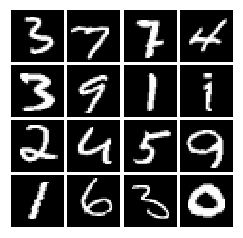

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=True)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## Random Noise

In [3]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform([batch_size, dim], -1, 1)

In [4]:
def sample_labels(batch_size, dim):
    """Generate one hot random labels.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing one-hot labels with shape [batch_size, dim]
    """
    labels = tf.random_uniform([batch_size, dim], 0, 1)
    return tf.one_hot(tf.argmax(labels, axis=1), dim)

## Discriminator

In [5]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images along with its labels, shape [batch_size, 784 + 10]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        layer_1 = tf.layers.dense(x, 256, tf.nn.leaky_relu, name="layer_1")
        layer_2 = tf.layers.dense(layer_1, 256, tf.nn.leaky_relu, name="layer_2")
        logits = tf.layers.dense(layer_2, 1, name="logit")
        return logits

## Generator

In [6]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim + label_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        layer_1 = tf.layers.dense(z, 1024, tf.nn.relu, name="layer_1")
        layer_2 = tf.layers.dense(layer_1, 1024, tf.nn.relu, name="layer_2")
        img = tf.layers.dense(layer_2, 784, tf.nn.tanh, name="image")
        return img

# Least Squares GAN

In [7]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    D_loss = 0.5 * (tf.reduce_mean((score_real - 1) ** 2) + tf.reduce_mean(score_fake ** 2))
    G_loss = 0.5 * tf.reduce_mean((score_fake - 1) ** 2)
    return D_loss, G_loss

# Optimizing our loss

In [8]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

    return D_solver, G_solver

## Putting it all together

In [9]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96
labels_dim = 10

# placeholder for images from the training dataset
x_image = tf.placeholder(tf.float32, [None, 784])
# scale images to be -1 to 1
x_image_preprocess = preprocess_img(x_image)
# placeholders for labels
x_label = tf.placeholder(tf.float32, [None, labels_dim])
# concate labels and images
x = tf.concat((x_image_preprocess, x_label), axis=1)

# random image_noise fed into our generator
z_image = sample_noise(batch_size, noise_dim)
# random label_nose fed into the generator
z_label = sample_labels(batch_size, labels_dim)
# concat image and noise
z = tf.concat((z_image, z_label), axis=1)

# generated images
G_sample = generator(z)
# concat generated images with fake labels
G_sample_with_labels = tf.concat((G_sample, z_label), axis=1)

with tf.variable_scope("") as scope:
    logits_real = discriminator(x)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample_with_labels)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!

In [10]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(deprocess_img(samples[:16]))
            plt.show()
            print()
        # run a batch of data through the network
        minibatch_x, minibatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x_image: minibatch_x,
                                                                     x_label: minibatch_y})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(deprocess_img(samples[:16]))
    plt.show()

## Train Conditional LSGAN! 

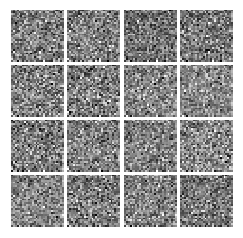


Iter: 0, D: 0.3777, G:0.4813
Iter: 50, D: 0.1189, G:0.7244
Iter: 100, D: 0.7531, G:2.679
Iter: 150, D: 0.633, G:0.2693
Iter: 200, D: 0.2562, G:0.7151


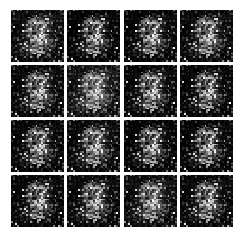


Iter: 250, D: 0.2868, G:0.2286
Iter: 300, D: 0.05136, G:0.5743
Iter: 350, D: 0.2221, G:1.027
Iter: 400, D: 0.1898, G:0.423
Iter: 450, D: 0.05011, G:0.6585


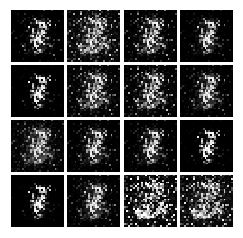


Iter: 500, D: 0.1826, G:0.2231
Iter: 550, D: 0.0732, G:0.4863
Iter: 600, D: 0.08542, G:0.3132
Iter: 650, D: 0.0803, G:0.6114
Iter: 700, D: 0.06682, G:0.3304


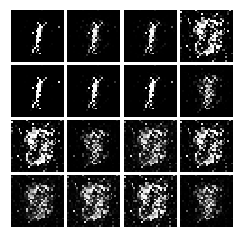


Iter: 750, D: 0.07048, G:0.5231
Iter: 800, D: 0.05047, G:0.5827
Iter: 850, D: 0.07881, G:0.4161
Iter: 900, D: 0.06877, G:0.5653
Iter: 950, D: 0.08802, G:0.1815


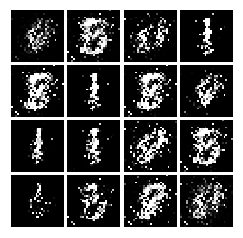


Iter: 1000, D: 0.1031, G:0.4561
Iter: 1050, D: 0.05673, G:0.3574
Iter: 1100, D: 0.09847, G:0.2266
Iter: 1150, D: 0.0532, G:0.3975
Iter: 1200, D: 0.0962, G:0.4384


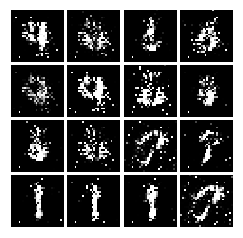


Iter: 1250, D: 0.06819, G:0.4594
Iter: 1300, D: 0.09773, G:0.3752
Iter: 1350, D: 0.1126, G:0.3274
Iter: 1400, D: 0.1088, G:0.3033
Iter: 1450, D: 0.1083, G:0.7924


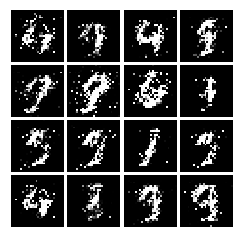


Iter: 1500, D: 0.09934, G:0.4949
Iter: 1550, D: 0.1139, G:0.3788
Iter: 1600, D: 0.1013, G:0.5402
Iter: 1650, D: 0.1256, G:0.2391
Iter: 1700, D: 0.1195, G:0.3459


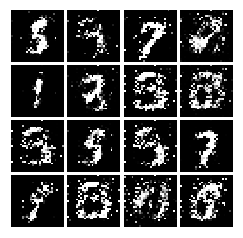


Iter: 1750, D: 0.1373, G:0.2749
Iter: 1800, D: 0.1631, G:0.2006
Iter: 1850, D: 0.1417, G:0.2751
Iter: 1900, D: 0.1602, G:0.4523
Iter: 1950, D: 0.1818, G:0.4153


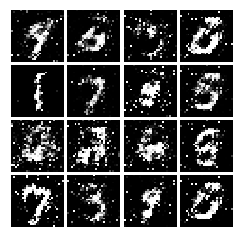


Iter: 2000, D: 0.1462, G:0.2821
Iter: 2050, D: 0.1531, G:0.3233
Iter: 2100, D: 0.1794, G:0.2121
Iter: 2150, D: 0.1709, G:0.2461
Iter: 2200, D: 0.1772, G:0.2219


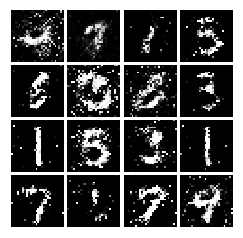


Iter: 2250, D: 0.1961, G:0.2185
Iter: 2300, D: 0.183, G:0.204
Iter: 2350, D: 0.2, G:0.2421
Iter: 2400, D: 0.2248, G:0.1173
Iter: 2450, D: 0.1822, G:0.2446


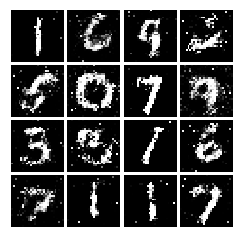


Iter: 2500, D: 0.1993, G:0.1945
Iter: 2550, D: 0.1902, G:0.2062
Iter: 2600, D: 0.1919, G:0.2247
Iter: 2650, D: 0.1994, G:0.2034
Iter: 2700, D: 0.1747, G:0.2347


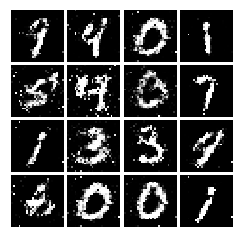


Iter: 2750, D: 0.1862, G:0.2237
Iter: 2800, D: 0.2037, G:0.2283
Iter: 2850, D: 0.2106, G:0.2828
Iter: 2900, D: 0.2002, G:0.196
Iter: 2950, D: 0.2042, G:0.3148


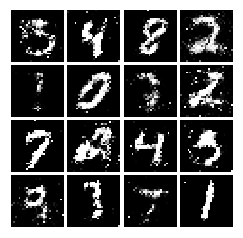


Iter: 3000, D: 0.1985, G:0.2274
Iter: 3050, D: 0.2136, G:0.2446
Iter: 3100, D: 0.2159, G:0.3328
Iter: 3150, D: 0.2099, G:0.1599
Iter: 3200, D: 0.2024, G:0.2232


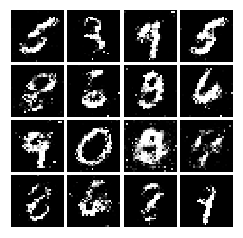


Iter: 3250, D: 0.2007, G:0.2176
Iter: 3300, D: 0.212, G:0.2302
Iter: 3350, D: 0.2466, G:0.2731
Iter: 3400, D: 0.2096, G:0.2433
Iter: 3450, D: 0.2224, G:0.1726


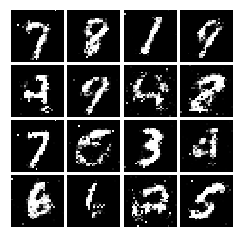


Iter: 3500, D: 0.2153, G:0.1579
Iter: 3550, D: 0.208, G:0.2076
Iter: 3600, D: 0.2102, G:0.1786
Iter: 3650, D: 0.2031, G:0.284
Iter: 3700, D: 0.2224, G:0.2049


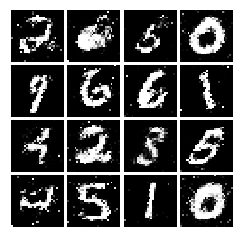


Iter: 3750, D: 0.2109, G:0.2467
Iter: 3800, D: 0.2065, G:0.1829
Iter: 3850, D: 0.2208, G:0.2163
Iter: 3900, D: 0.2102, G:0.1642
Iter: 3950, D: 0.2233, G:0.2326


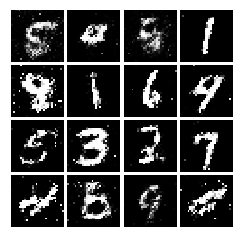


Iter: 4000, D: 0.2177, G:0.2223
Iter: 4050, D: 0.2263, G:0.1495
Iter: 4100, D: 0.2404, G:0.1516
Iter: 4150, D: 0.2093, G:0.1863
Iter: 4200, D: 0.2373, G:0.1643


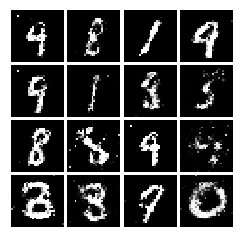


Iter: 4250, D: 0.2136, G:0.1691
Final images


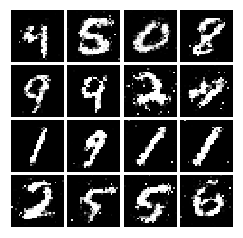

In [11]:
sess = get_session()
sess.run(tf.global_variables_initializer())
run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Conclusion

It seems to me that images are more sharp with conditional LSGAN than they were with Conditional Vanialla GAN.

# Showing that Vanila Conditional GAN is able to generate the similar looking images by using the labels

In [12]:
def get_fixed_labels(batch_size, label_num):
    """
    Generate the labels to use in the Conditional GAN
    """
    labels = np.zeros((batch_size, 10))
    labels[np.arange(batch_size), label_num] = 1
    return labels

### Generating samples similar to digit $7$

** In the below code, I am using the trick that you can pass values to a tensorflow variables**

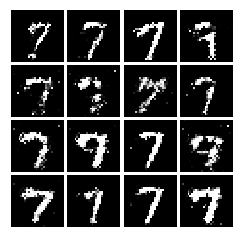

In [14]:
samples = sess.run(G_sample, feed_dict={z_label:get_fixed_labels(batch_size, 7)})
fig = show_images(samples[:16])
plt.show()

** Conclusion:** As previously, there are confusions between $7$ and $9$.

### Generating samples similar to digit $3$

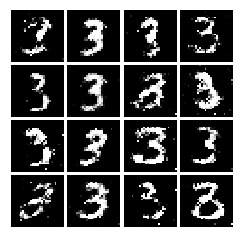

In [15]:
samples = sess.run(G_sample, feed_dict={z_label:get_fixed_labels(batch_size, 3)})
fig = show_images(samples[:16])
plt.show()